In [12]:
import numpy as np
import pandas as pd
import pickle

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from validation import TimeSeriesWalkingForwardCV, TimeSeriesWindowCV
from training import *
from metrics import *
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

plt.rcParams["figure.figsize"] = (40, 20)

In [13]:
def load_data(folder_name: str):
    data_cp = pd.read_csv(f'data/{folder_name}/data.csv')
    data_cp.date_time = pd.to_datetime(data_cp.date_time)
    features_scaled = pickle.load(open(f'data/{folder_name}/features_scaled', 'rb'))
    Y = pd.read_csv(f'data/{folder_name}/y.csv')
    
    return data_cp, features_scaled, Y

data_cp, features_scaled, Y = load_data('data_v4')

In [14]:
features = features_scaled[24*60:-24*30]
targets = Y[24*60:-24*30]
dates = data_cp.date_time.dt.date[24*60:-24*30]

In [15]:
def MAE(x, y):
    return (np.abs(x - y)).mean(axis=0)

def RelativeAE(x, y):
    return (np.abs(x - y)).sum(axis=0) / np.abs(y).sum(axis=0)

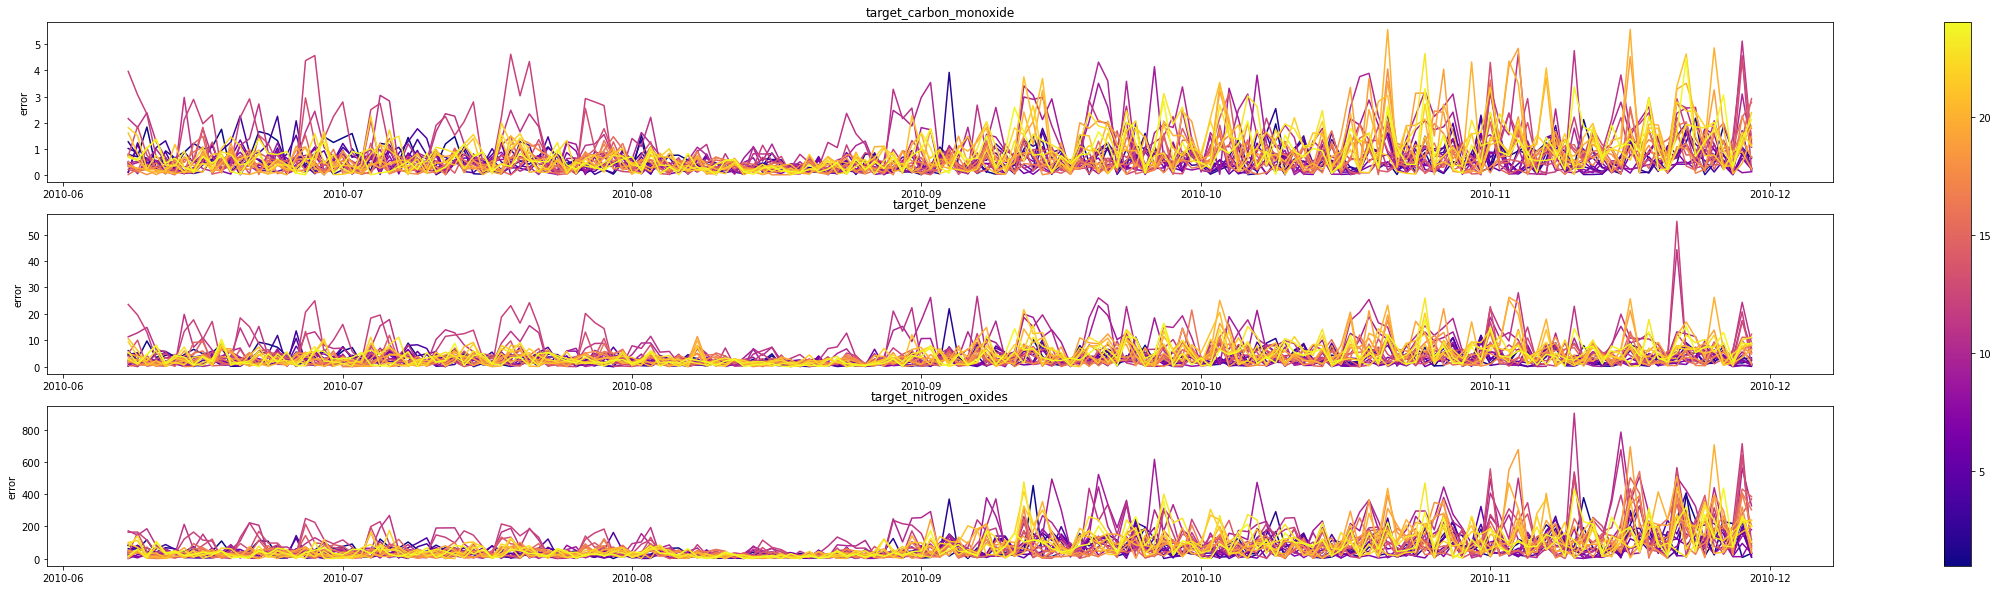

In [72]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWindowCV(Ridge, 24*30, 24, 24, fig, axs, dates, param_grid={'alpha': [0.1, 0.5, 1, 2], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)

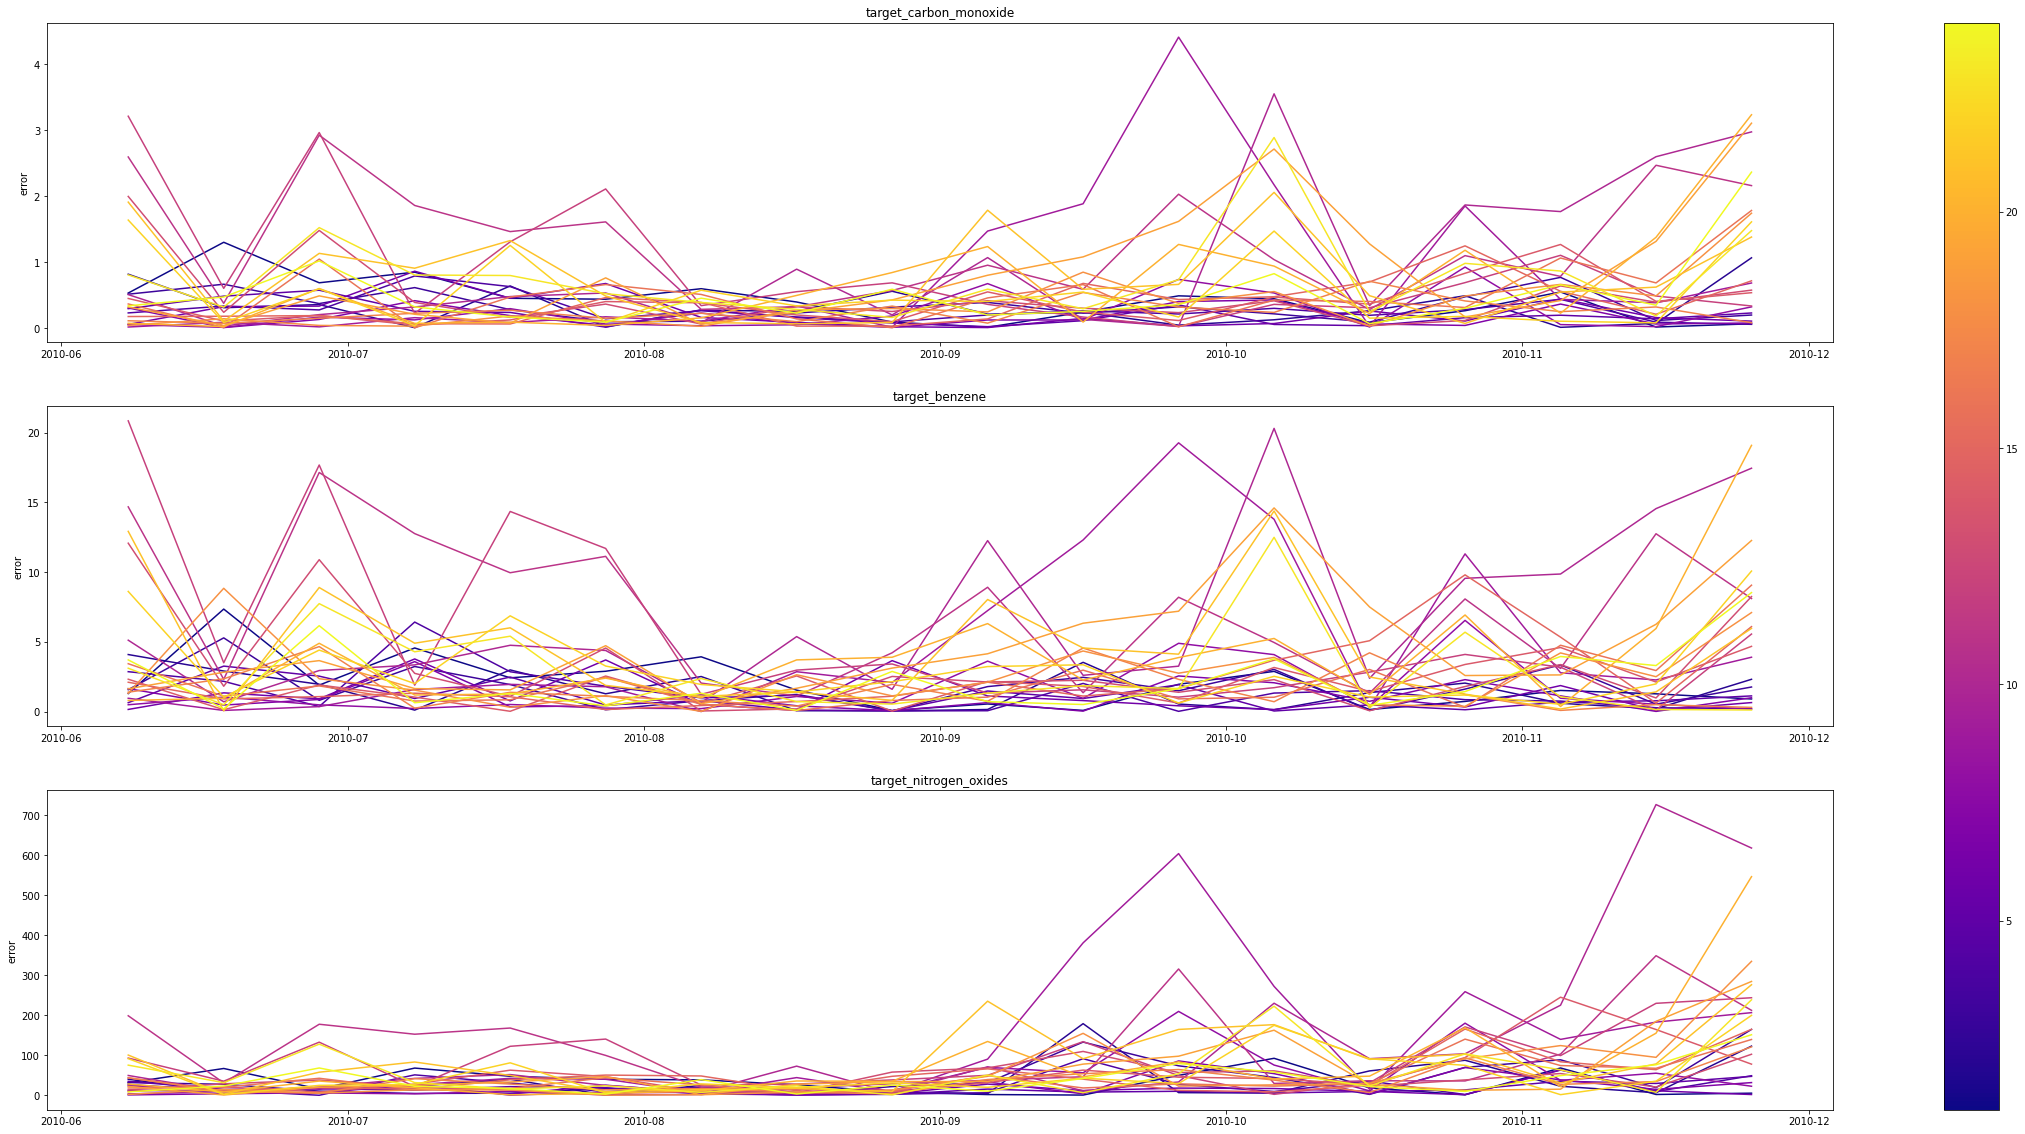

In [21]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWindowCV(XGBRegressor, 24*30, 24, 240, fig, axs, dates, param_grid={'max_depth': [10], 'n_estimators': [20], 'learning_rate': [0.1], 'min_child_weight': [3]})
optimizer_forest.fit(features, targets, MAE)

In [ ]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWalkingForwardCV(Ridge, test_size=24, n_splits=100, fig=fig, axs=axs, dates=dates, param_grid={'alpha': [0.05], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWalkingForwardCV(XGBRegressor, test_size=24, n_splits=20, fig=fig, axs=axs, dates=dates, param_grid={'max_depth': [30], 'n_estimators': [30], 'learning_rate': [0.1], 'min_child_weight': [3], 'reg_alpha': [0.1]})
optimizer_forest.fit(features, targets, MAE)

In [ ]:
def save_model(name: str, model: list):
    pickle.dump(model, open(f'models/{name}', 'wb'))

In [ ]:
h = 24*10

In [ ]:
%%time
models = train_models(XGBRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 30, 'n_estimators': 30, 'learning_rate': 0.1, 
                                                                             'min_child_weight': 3, 'reg_alpha': 0.1, 'subsample': 0.8, 'gamma': 1, 'n_jobs': 6})

In [ ]:
save_model('xgboost_v3.1', models)

In [ ]:
result = predict(models, features_scaled[-h])

In [ ]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 0], alpha=0.6)
plt.plot(list(range(len(Y))), Y['target_carbon_monoxide'], alpha=0.5)

In [ ]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 1], alpha=0.7)
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.6)

In [ ]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 2])
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'], alpha=0.3)

In [ ]:
def error(result, Y, h, metric):
    for i in range(3):
        err = metric(result[:, i], Y.iloc[-h:, i])
        print(f'{Y.columns[i]} {metric.__name__} : {err}')

In [ ]:
error(result, Y, h, RelativeAE)

In [ ]:
error(result, Y, h, MAE)

In [ ]:
models_l = train_models(RandomForestRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 10, 'n_estimators': 10, 'min_samples_leaf': 3, 'n_jobs': 6})

In [ ]:
result_l = predict(models_l, features_scaled[-h])

In [ ]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result_l[:, 1], alpha=0.7)
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.6)

In [ ]:
save_model('forest_v1', models_l)

In [ ]:
MAE(Y['target_benzene'][-h:], result_l[:, 1])

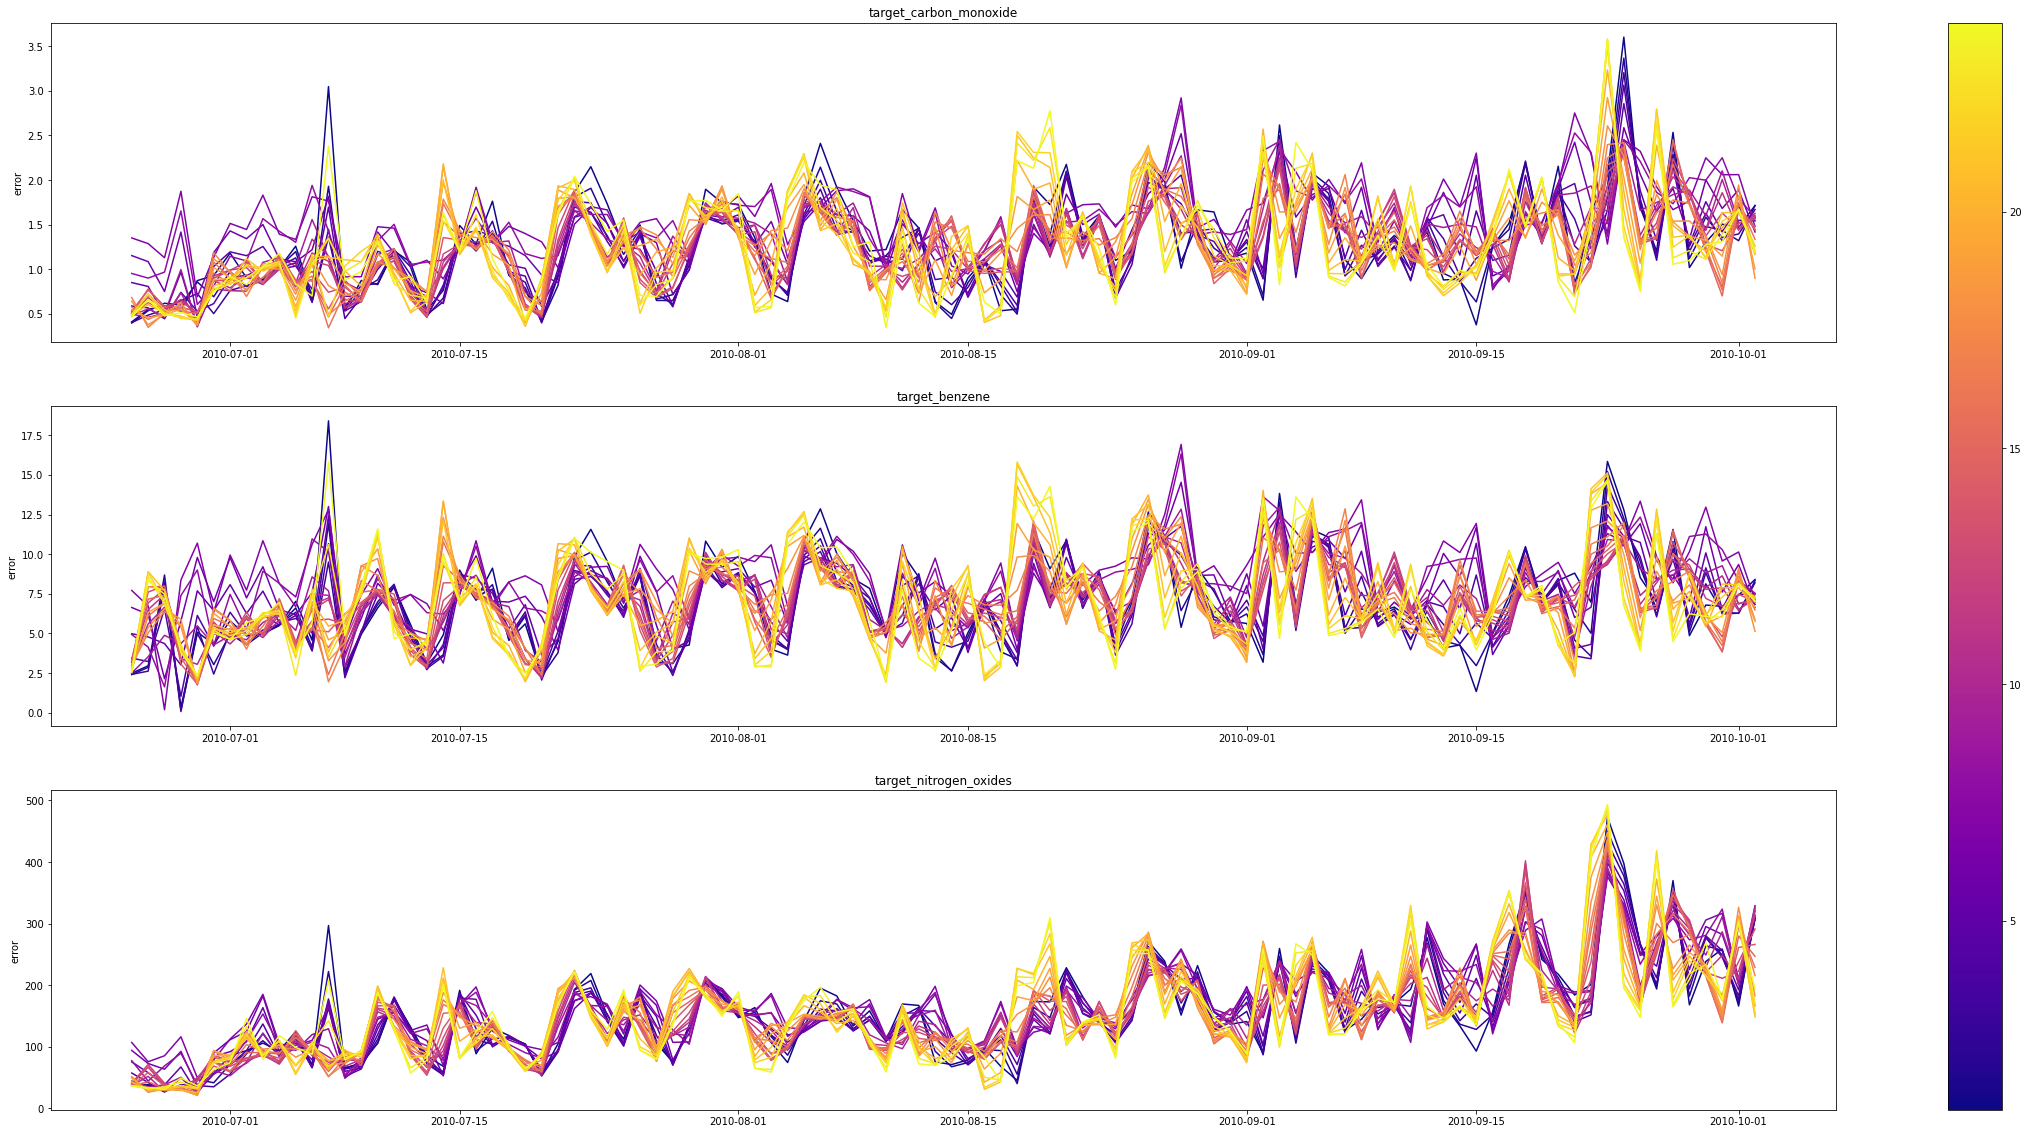

In [6]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

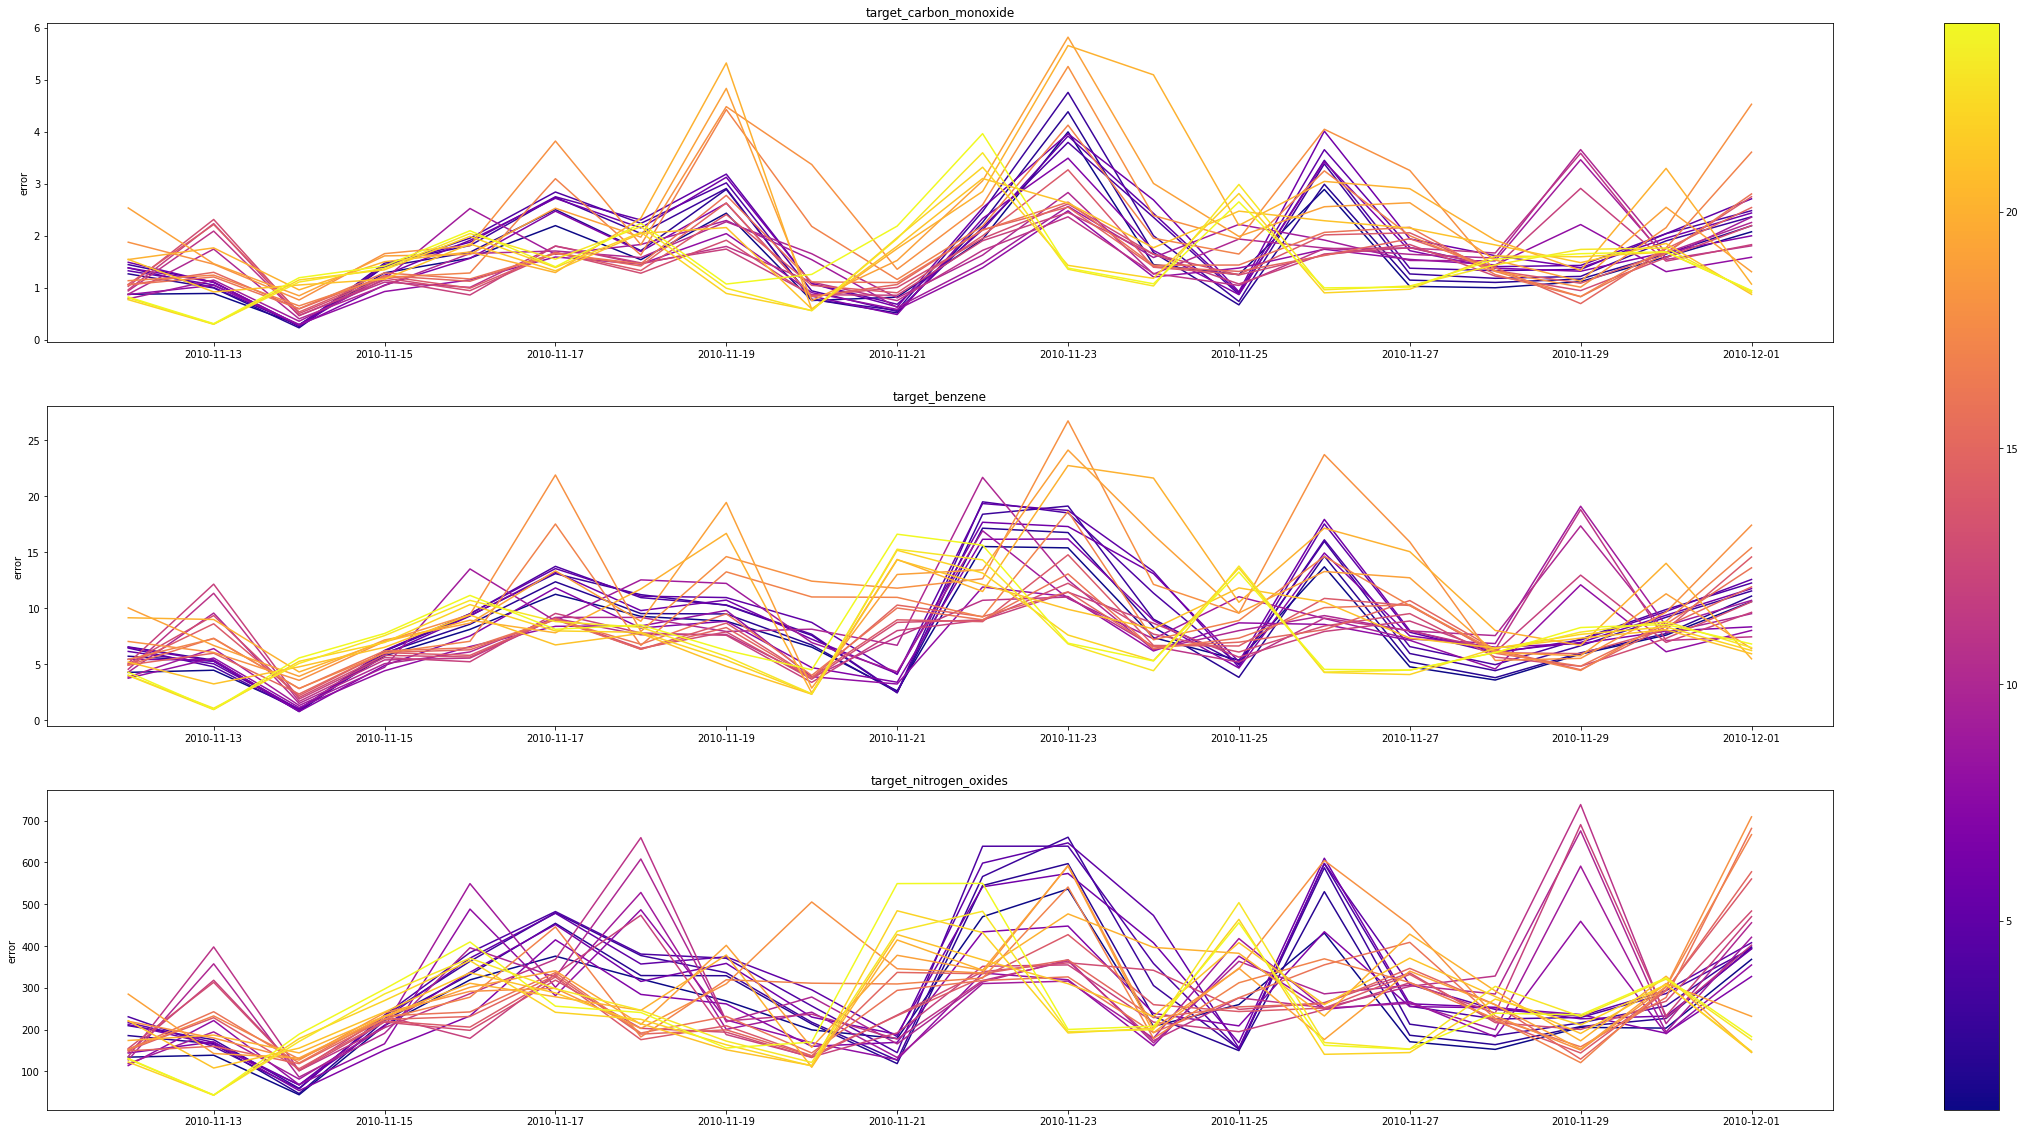

In [11]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWalkingForwardCV(XGBRegressor, test_size=24, n_splits=20, fig=fig, axs=axs, dates=dates, param_grid={'max_depth': [30], 'n_estimators': [30], 'learning_rate': [0.1], 'min_child_weight': [3], 'reg_alpha': [0.1]})
optimizer_forest.fit(features, targets, MAE)

In [18]:
def save_model(name: str, model: list):
    pickle.dump(model, open(f'models/{name}', 'wb'))

In [9]:
h = 24*10

In [51]:
%%time
models = train_models(XGBRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 30, 'n_estimators': 30, 'learning_rate': 0.1, 
                                                                             'min_child_weight': 3, 'reg_alpha': 0.1, 'subsample': 0.8, 'gamma': 1, 'n_jobs': 6})

Wall time: 40min 20s


In [28]:
save_model('xgboost_v3.1', models)

In [52]:
result = predict(models, features_scaled[-h])

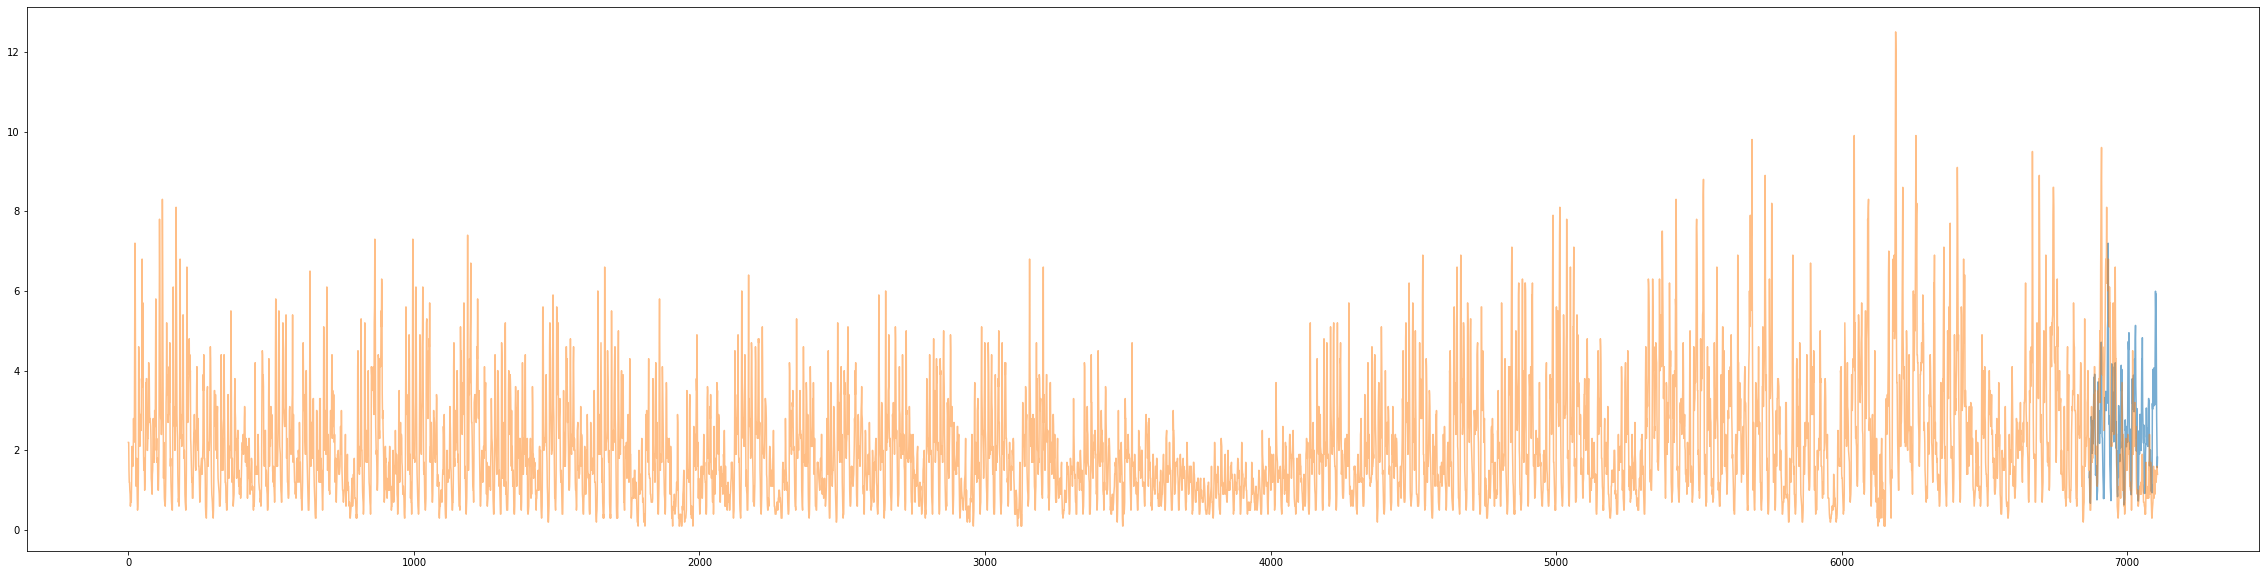

In [53]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 0], alpha=0.6)
plt.plot(list(range(len(Y))), Y['target_carbon_monoxide'], alpha=0.5)

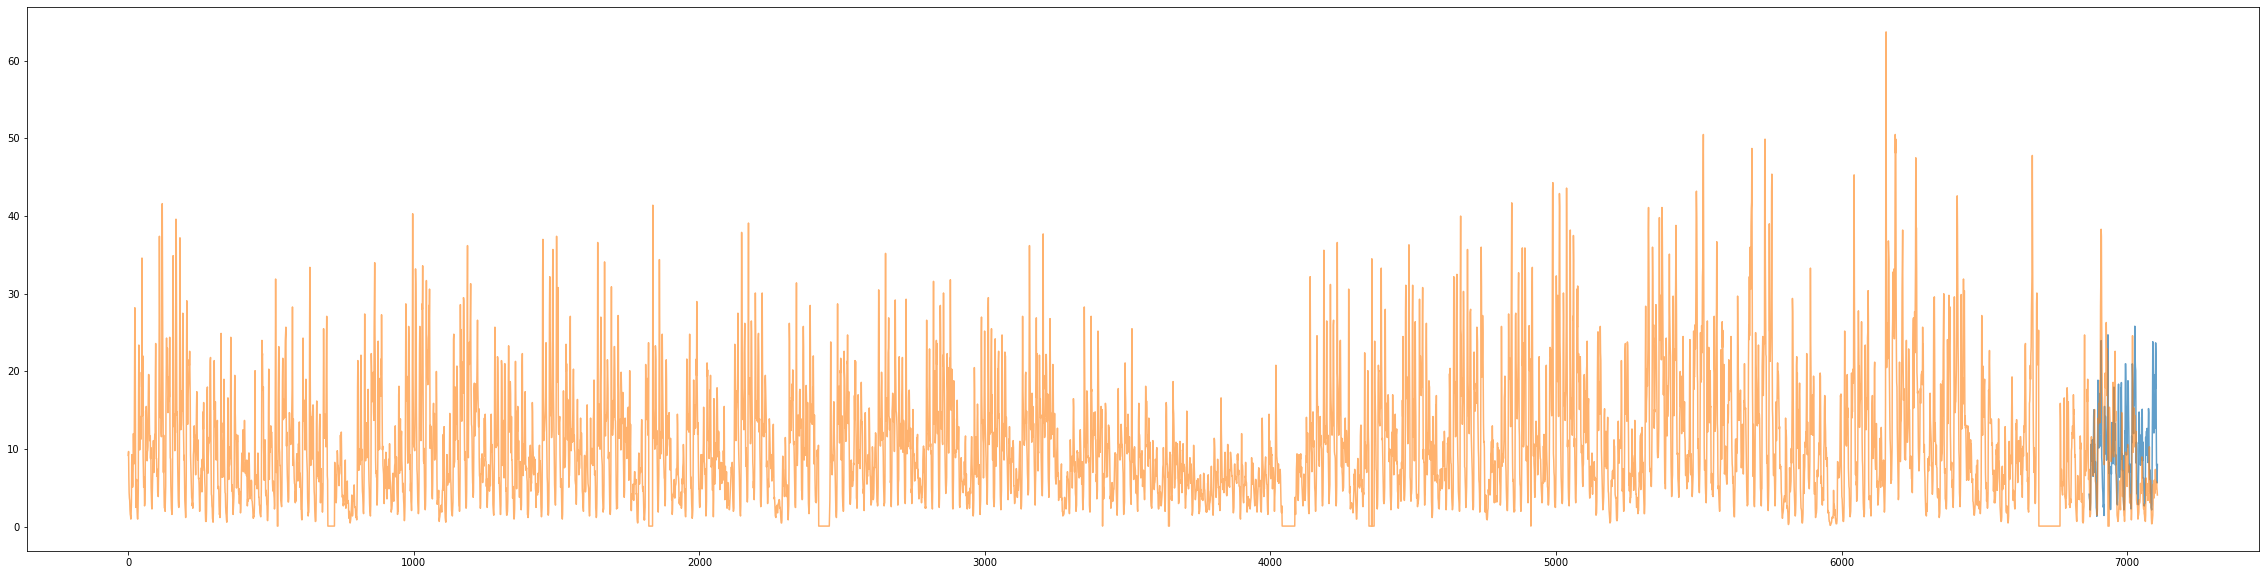

In [54]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 1], alpha=0.7)
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.6)

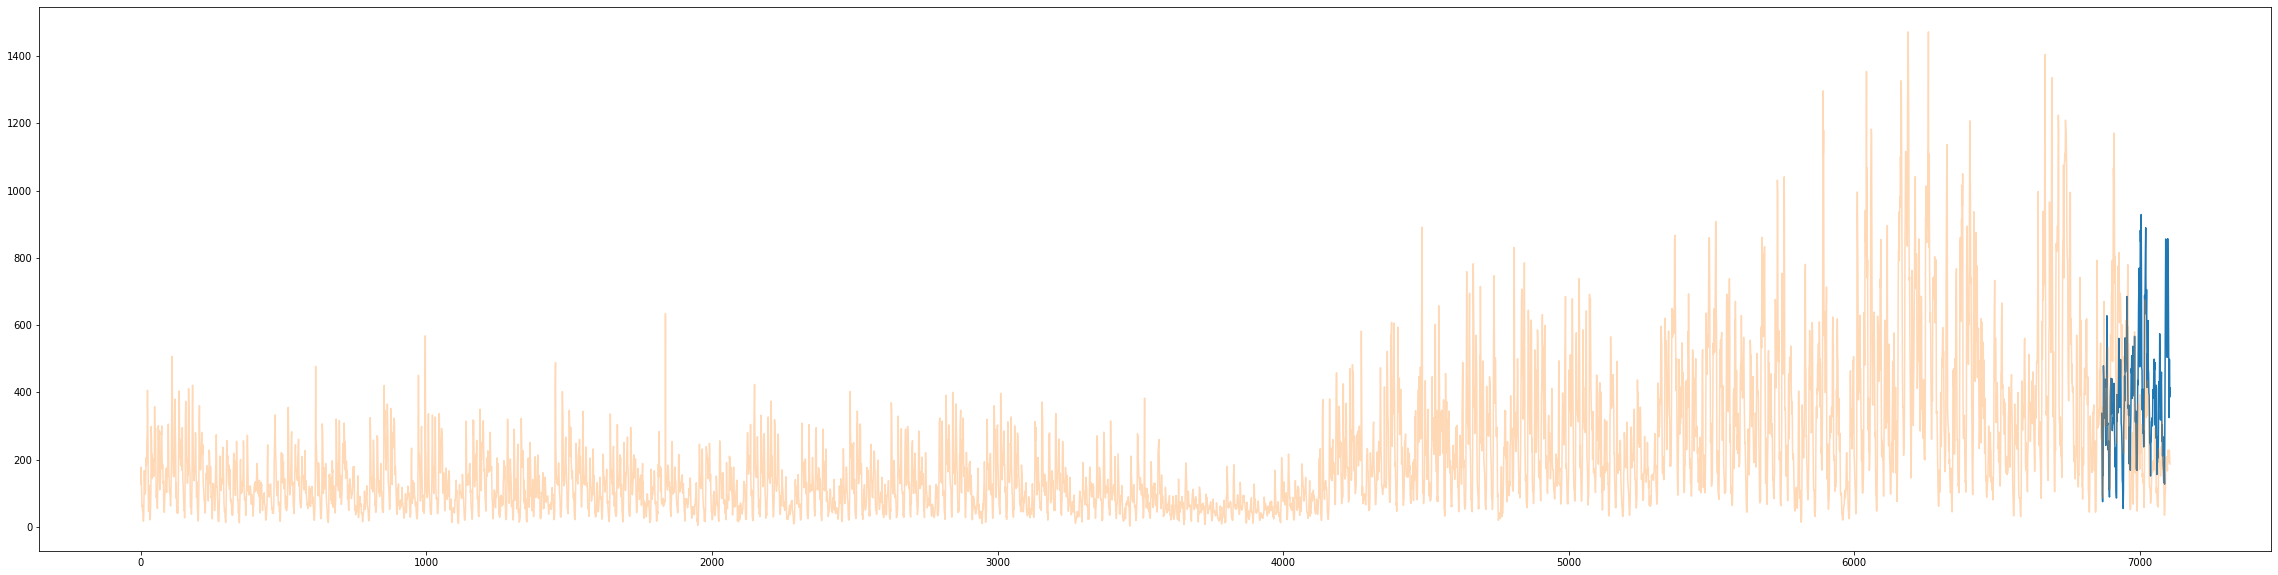

In [55]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 2])
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'], alpha=0.3)

In [93]:
def error(result, Y, h, metric):
    for i in range(3):
        err = metric(result[:, i], Y.iloc[-h:, i])
        print(f'{Y.columns[i]} {metric.__name__} : {err}')

In [57]:
error(result, Y, h, RelativeAE)

target_carbon_monoxide RelativeAE : 0.5771332079589209
target_benzene RelativeAE : 0.7096712491104618
target_nitrogen_oxides RelativeAE : 0.6903002311916431


In [58]:
error(result, Y, h, MAE)

target_carbon_monoxide MAE : 1.3574653995533785
target_benzene MAE : 5.716993304292361
target_nitrogen_oxides MAE : 218.98192896525063


In [20]:
models_l = train_models(Lasso, features_scaled[:-h], Y[:-h], h, params={'alpha': 2, 'tol': 1e-4, 'max_iter': 1000})

In [21]:
save_model('lasso_v2', models_l)

In [27]:
result_l = predict(models_l, features_scaled[-h])

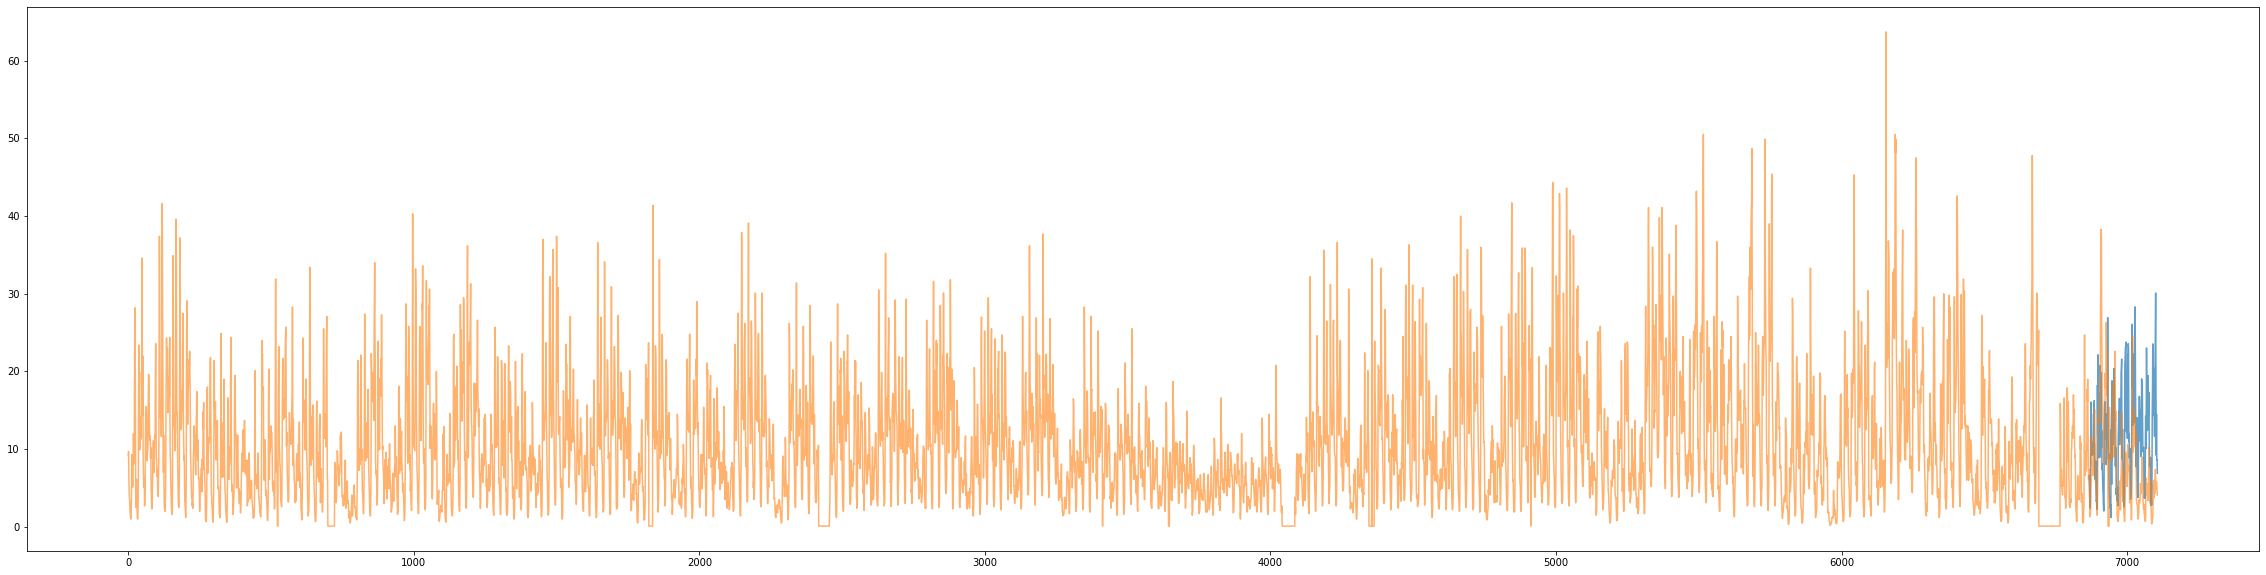

In [12]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result_l[:, 1], alpha=0.7)
plt.plot(list(range(len(Y))), Y['target_benzene'], alpha=0.6)

In [16]:
save_model('forest_v1', models_l)

In [13]:
MAE(Y['target_benzene'][-h:], result_l[:, 1])

7.140307438342152

In [77]:
import stacking
import importlib
import training
importlib.reload(stacking)
importlib.reload(training)

<module 'training' from 'C:\\Users\\asus\\Python\\PollutionAnalysis\\training.py'>

In [101]:
ridge = Ridge(alpha=2, tol=1e-4)
lasso = Lasso(alpha=2, tol=1e-4, max_iter=1000)
xgb1 = XGBRegressor(n_estimators=10, max_depth=10, min_child_weight=3, reg_alpha=0.1, n_jobs=4)
forest = RandomForestRegressor(n_estimators=12, max_depth=10, max_features='sqrt', n_jobs=4)

In [102]:
models_stacking = stacking.StackingModel(estimators=[('xgb', xgb1), ('lasso', lasso), ('forest', forest)], final_estimator=LinearRegression(), horizons_n=24*10)

In [103]:
models_stacking.fit(features_scaled[:-h], Y[:-h])

In [100]:
save_model('stacking_v1_data_v4', models_l)

In [104]:
result_stacking = models_stacking.predict(features_scaled[-h])

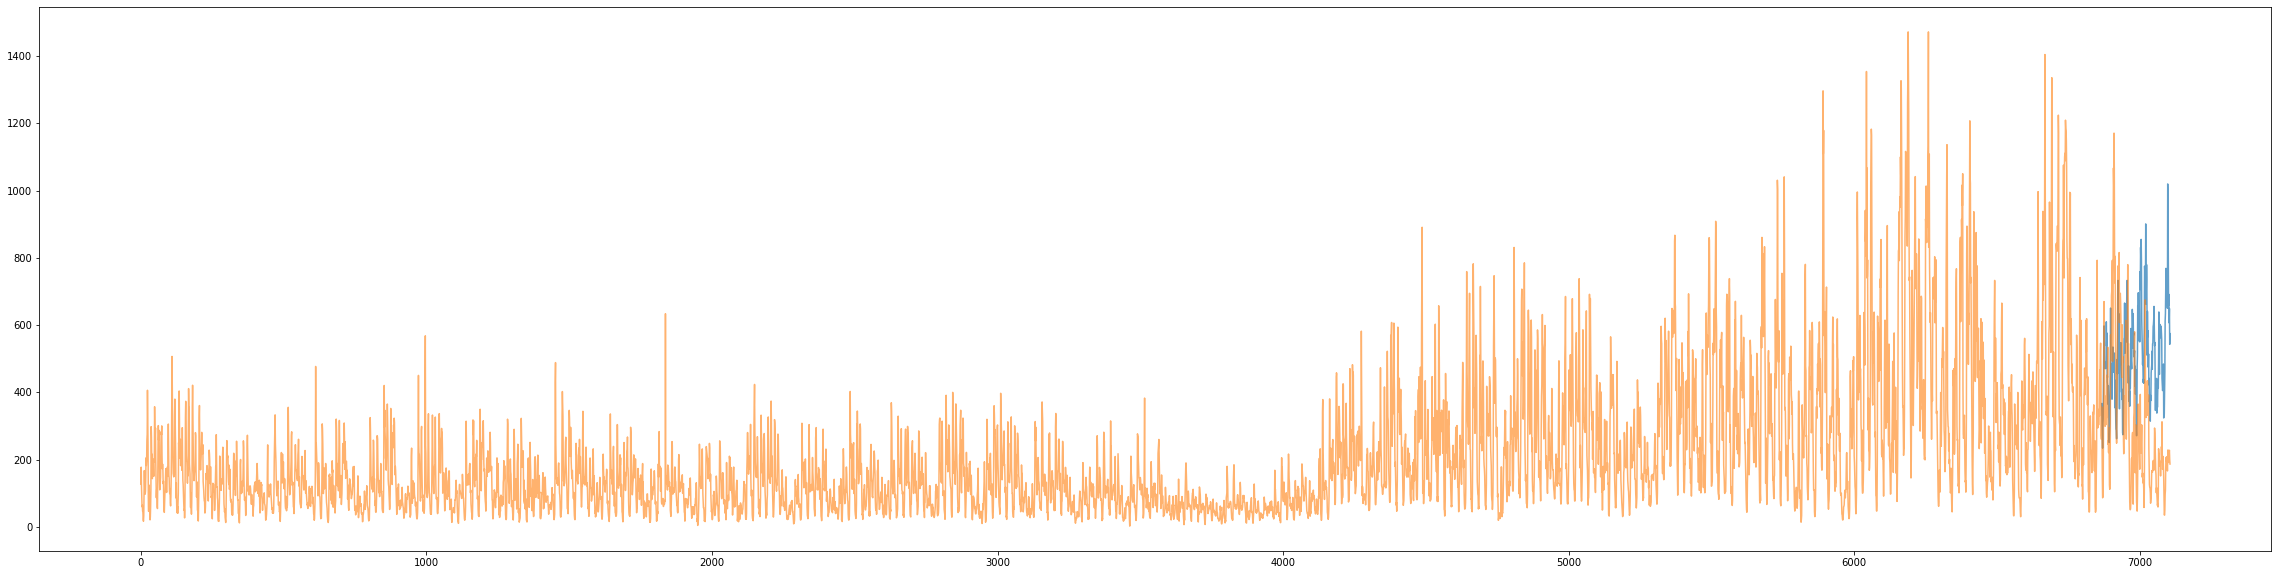

In [108]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result_stacking[:, 2], alpha=0.7)
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'], alpha=0.6)